In [1]:
### Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNetCV,LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

### Auxiliary functions to be used during analysis
from aux_functs import *

# Objective


The visibility of a given sport might lead to an increase in public interest and number of players.

The objective of the following analysis is to understand how a set of variables, related to fooball's visibility, influence the evolution of registered football players, in Portugal, across seasons.  



In [2]:
### Load Data

# User friendly feature names  
new_features = {'Número Praticantes':'Players',
                'Scoring System':'Score',
                'Organização competições internacionais':'Organizer',
                'Prémios individuais':'Awards',
                'Ranking FIFA': 'Ranking',
                'Indice de desenvolvimento humano': 'HDI',
                'Época':'Season'}

#Load data, rename features and change Época to index
seasons_df = pd.read_excel('Modelo_Futebol.xlsx',sheet_name="FUTEBOL").rename(columns = new_features).set_index('Season',drop = True)
seasons_df

,Players,Score,Organizer,Awards,Ranking,HDI
Season,,,,,,
2000-2001,99841,0.0,0,0,5,0.792
2001-2002,102108,25.0,0,0,4,0.798
2002-2003,106690,0.0,0,0,11,0.799
2003-2004,108108,75.0,1,0,8,0.805
2004-2005,107124,0.0,0,0,6,0.809
2005-2006,107604,50.0,0,0,6,0.813
2006-2007,110583,0.0,0,0,6,0.811
2007-2008,115174,25.0,0,1,7,0.814
2008-2009,116506,0.0,0,0,13,0.817


#   Features Exploration and Engineering 

The data set is very small, comprised of only 20 observations, each corresponding to a different season. For every observation we have data about the number of registered players, 4 visibility related features, and 1 development related feature.  


## Target Variable

The target variable is the feature  **Players**, containing the number of registered football players per season. 

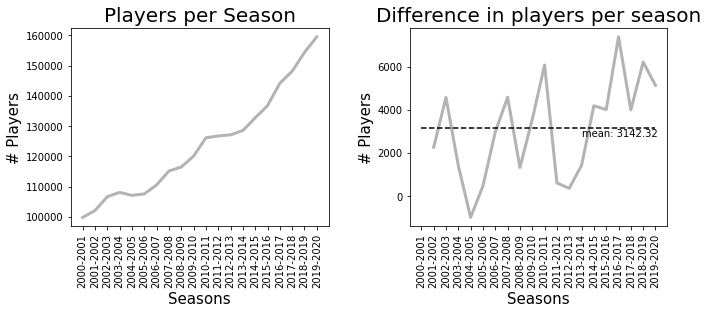

In [3]:
###Plot Target variable

#Define fig
fig,axs = plt.subplots(1, 2, figsize=(10,5)) # De

#Font Sizes
l_font = 15
t_font = 20



# Plot Players per season
axs[0].plot(seasons_df.index,seasons_df['Players'],color='#B3B3B3',linewidth = 3)
axs[0].set_xlabel('Seasons',fontsize = l_font)
axs[0].set_ylabel('# Players',fontsize = l_font)
axs[0].set_title('Players per Season',fontsize = t_font)
axs[0].set_xticklabels(seasons_df.index, rotation=90)


# Plot changes per season
axs[1].plot(seasons_df.index,seasons_df['Players'].diff(),color='#B3B3B3',linewidth = 3)
axs[1].plot([seasons_df.index[0], seasons_df.index[-1]],
            [seasons_df['Players'].diff().mean(), seasons_df['Players'].diff().mean()],
            color='k',
            linestyle = '--')
axs[1].set_xlabel('Seasons',fontsize = l_font)
axs[1].set_ylabel('# Players',fontsize = l_font)
axs[1].set_title('Difference in players per season',fontsize = t_font)
axs[1].text(seasons_df.index[13],seasons_df['Players'].diff().mean()-400,'mean: '+str(np.round(seasons_df['Players'].diff().mean(),2)))
axs[1].set_xticklabels(seasons_df.index, rotation=90)


fig.tight_layout(pad=3.0)

plt.show()


**Fig1.** Left: evolution of the number of players per season. Right: Difference in the number of players between seasons. 

----------

The number of registered players increased continuously from season 2000-2001 to season 2019-2020, with the exception of season 2004-2005, a growth close to 60%. On average there was an increase of approximately 3142 players per season with a considerable standard deviation of 2359 players.

Some potentially interesting observations:

1- Since 2014-2015 there's an above average growing of the number of players, with a clear peak in 2016-2017, the season after Portugal won the European Football Championship. 

2- There were two periods of notoriously slower growth, the first from 2003-2004 to 2005-2006, the second from 2010-2011 to 2013-2014.

3- The only season with negative growth was 2004-2005, interestingly the one immediately following Portugal's organization of the European Championship. One can speculate of a regression to the mean following several seasons of anticipation and investment.

## Explanatory Features


### The original explanatory features are 

- **Score:** Result of a scoring system that takes in consideration the national football team's results in international competitions as well as individual awards. 
- **Organizer:** If the country organized an international competition in that season.
- **Awards:** Individual awards received by the national team players and staff.
- **Ranking:** FIFA Ranking of the national team for the season.
- **HDI:** Human Development Index for Portugal in each season.


The first 4 are connected to football and its visibility, but HDI is not. It can influence the number of registered players, given that the index reflects the development of the country, but it's not directly related to the target variable. For didactic purposes I won't drop the feature, but will perform a separate analysis whenever necessary.     


### Features Engineering

Observations in the different features correspond to one season but they necessarily influence other seasons close by. For instance, Portugal only organized the European Championship in 2004, but all the anticipation leading to the event, and the outcome of the event itself, certainly impacted football's visibility in the season(s) before and after. 


####  Score and Awards

Observations in both Score and Awards features can only influence the number of registered players in the seasons that follow. Also, the influence of a good score or award has a certain momentum which likely impacts more than one season. Following this rational I created two new features **MScore** and **MAwards**, resulting from shifting the observations in both features one season into the feature and posteriorly applying a rolling mean of three seasons. 


#### Ranking

The Raking feature is slightly different, as the FIFA Ranking changes several times along the year. By having just one value per season one looses information about the other values on the same season as well as the pattern of evolution, factors that can impact visibility in different ways. I created a new feature **MRanking**  just applying a rolling mean of three seasons to the feature, mimicking a sense of continuity.  


#### Organizer

The organization of a competition has an effect that covers not only that season but also seasons before and after. To capture this effect I applied a gaussian filter, with a three seasons window and a standard deviation of 1, to the Organizer feature creating the new feature **MOrganizer**.



In [4]:
### Create New Features 


#Awards
S97_98 = 0
S98_99 = 0
S99_00 = 1 #Balon D'OR Figo
prémios = np.array(seasons_df['Awards'])
absent_array = np.insert(prémios, 0, [S97_98,S98_99,S99_00], axis=0)
absent_df = pd.DataFrame(absent_array, columns = ['Awards']).shift(1).rolling(window=3).mean()
seasons_df['MAwards'] = absent_df.iloc[3:,0].tolist()



#Score
S97_98 = 0
S98_99 = 0
S99_00 = 50 #Euro 00 Semis
score = np.array(seasons_df['Score'])
absent_array = np.insert(score, 0, [S97_98,S98_99,S99_00], axis=0)
absent_df = pd.DataFrame(absent_array, columns = ['Score']).shift(1).rolling(window=3).mean()
seasons_df['MScore'] = absent_df.iloc[3:,0].tolist()


#Ranking
'''
The rankings bellow were calculated, using data from the FIFA website, as follows:
S98_99 = mean(best ranking 98, worst ranking 98, best ranking 99, worst ranking 99)
S99_00 = mean(best ranking 99, worst ranking 99, best ranking 00, worst ranking 00)
'''
S98_99 = 25
S99_00 = 13 #Ranking on Season 99-00
ranking = np.array(seasons_df['Ranking'])
absent_array = np.insert(ranking, 0, [S98_99,S99_00], axis=0)
absent_df = pd.DataFrame(absent_array, columns = ['Ranking']).rolling(window=3).mean()
seasons_df['MRanking'] = absent_df.iloc[2:,0].tolist()



#Organizer
org = np.array(seasons_df['Organizer'])
padding_array = np.insert(org, [0,-1], [0,0], axis=0)
padding_df = pd.DataFrame(padding_array, columns = ['Organizer']).rolling(3, win_type='gaussian',center=True).sum(std=1)
seasons_df['MOrganizer'] = padding_df.iloc[1:-1,0].tolist()

#Data Set with new features
seasons_df.head()

,Players,Score,Organizer,Awards,Ranking,HDI,MAwards,MScore,MRanking,MOrganizer
Season,,,,,,,,,,
2000-2001,99841,0.0,0,0,5,0.792,0.333333,16.666667,14.333333,0.000000
2001-2002,102108,25.0,0,0,4,0.798,0.333333,16.666667,7.333333,0.000000
2002-2003,106690,0.0,0,0,11,0.799,0.333333,25.000000,6.666667,0.606531
2003-2004,108108,75.0,1,0,8,0.805,0.000000,8.333333,7.666667,1.000000
2004-2005,107124,0.0,0,0,6,0.809,0.000000,33.333333,8.333333,0.606531


## Original and engineered features

Let's look at the effect of the transformations in the features. 

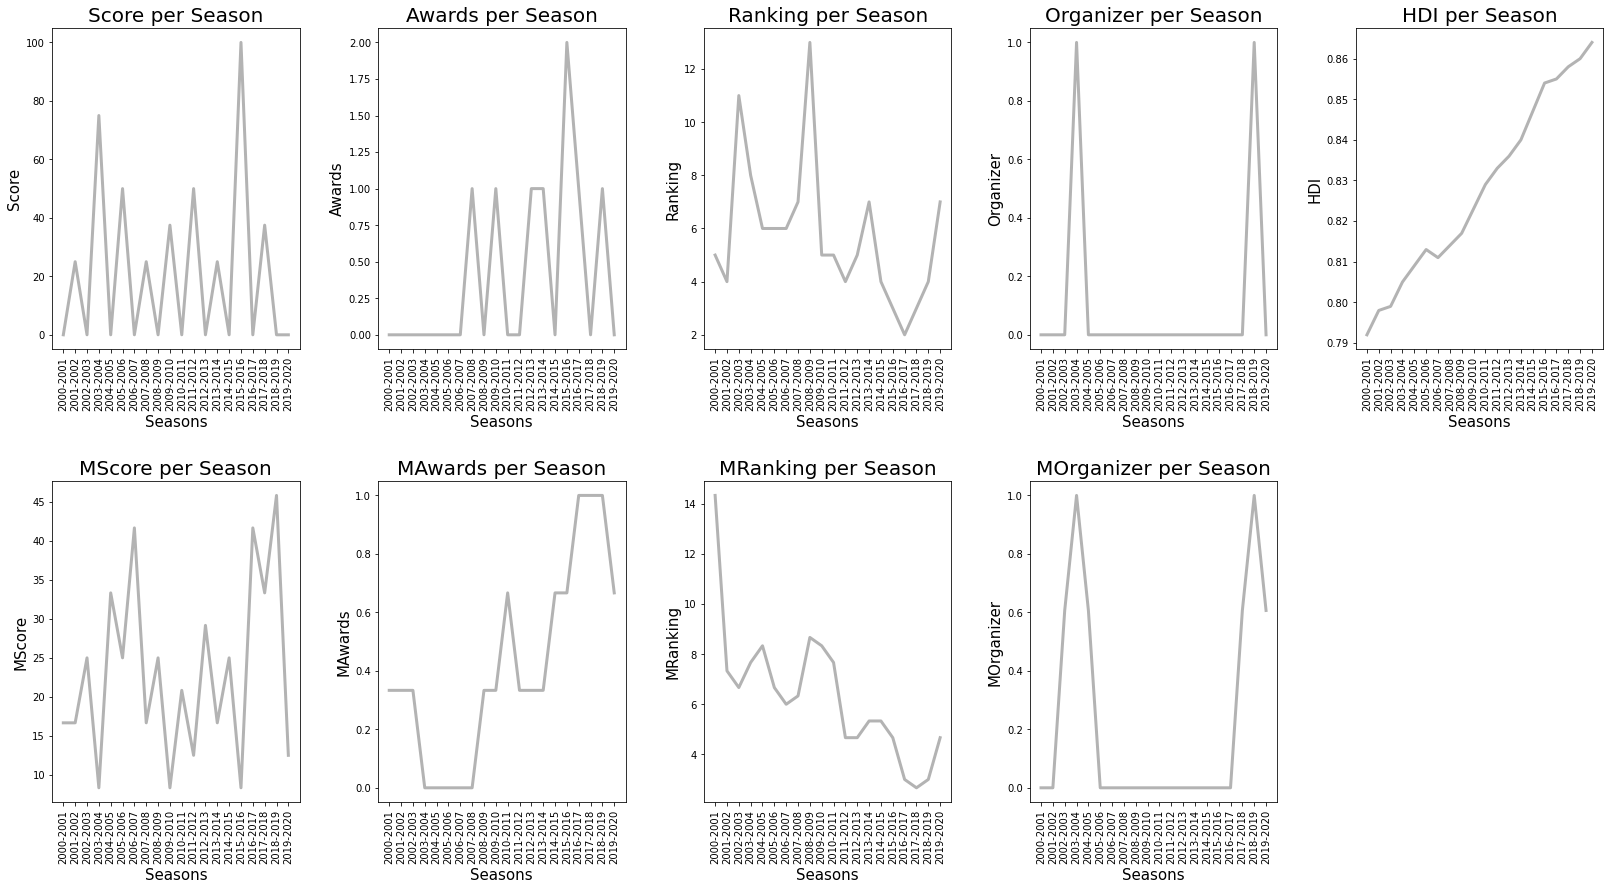

In [5]:
###Plot Features

#Feature Names
features = ['Score','MScore','Awards','MAwards','Ranking','MRanking','Organizer','MOrganizer','HDI']


#Define Fig
fig,axs = plt.subplots(2, 5, figsize=(23,13)) # De

#Start subplot indices
rx = 0
cx = 0

#Font Sizes
l_font = 15
t_font = 20
txt_font = 12


#Plot features
for f in range(len(features)):
    axs[rx,cx].plot(seasons_df.index,seasons_df[features[f]],color='#B3B3B3',linewidth = 3)
    axs[rx,cx].set_xlabel('Seasons',fontsize = l_font)
    axs[rx,cx].set_ylabel(features[f],fontsize = l_font)
    axs[rx,cx].set_title(features[f] + ' per Season',fontsize = t_font)
    axs[rx,cx].set_xticklabels(seasons_df.index, rotation=90)
    
    # change subplot indices
    if f%2 == 0:
        rx = 1
    else:
        rx = 0
        cx = cx + 1

#Delete empty axes
axs[1,4].axis("off")


fig.tight_layout(pad=3.0)
plt.show()

**Fig2.** Top: Original features. Bottom: Engineered features.

----------


# Correlation between features and target variables


An healthy way to start exploring which features are more useful in explaining the evolution of the number of registered players across seasons is to see how they correlate with the target variable and between themselves. 

## Correlation coefficients and confusion matrix


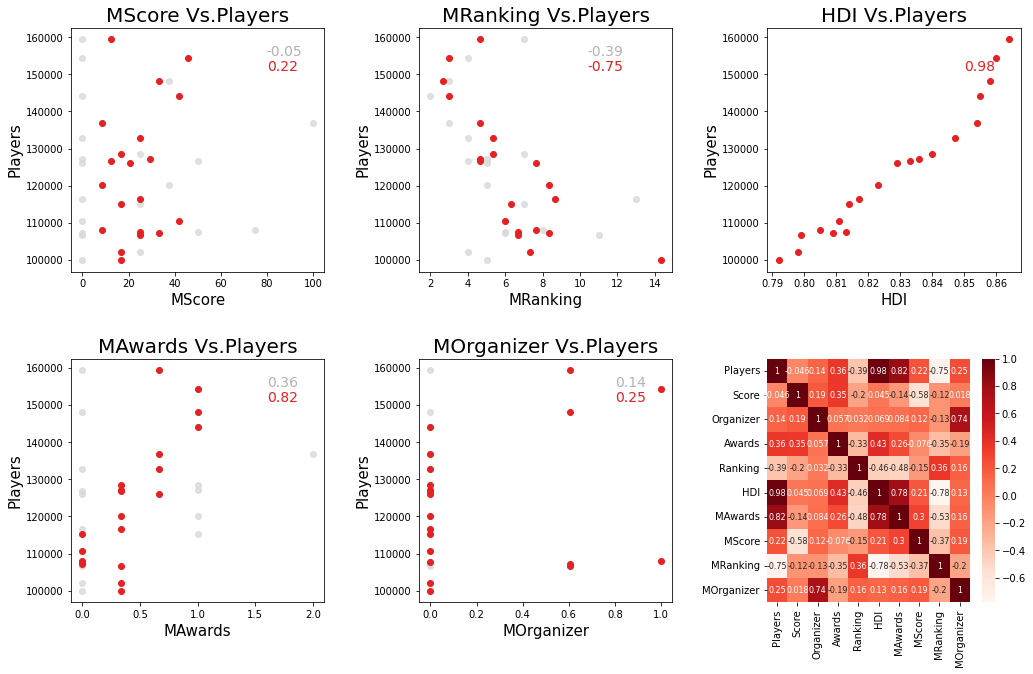

In [6]:
### Plot correlations

#Features with IDH
features_0 = ['Score','Awards','Ranking','Organizer']
#Features without IDH
features_1 = ['MScore','MAwards','MRanking','MOrganizer','HDI']


#Define Fig
fig,axs = plt.subplots(2, 3, figsize=(15,10)) # De

#Start subplot indices
rx = 0
cx = 0

#Font Sizes
l_font = 15
t_font = 20
txt_font = 12


# Plot scatters 
for f in range(len(features_1)):
    if  f <= len(features_0)-1:
        text_pos = seasons_df[features_0[f]].max() - seasons_df[features_0[f]].max()*0.2
        
        corrS0 = np.round(np.corrcoef(seasons_df[features_0[f]],seasons_df['Players'])[0,1],2)
        axs[rx,cx].scatter(seasons_df[features_0[f]],seasons_df['Players'],color='#D9D9D9',alpha=0.8)
        axs[rx,cx].text(text_pos, 155000, str(corrS0), color='#B3B3B3',fontsize = 14)
    else:
        text_pos = 0.85
        
    
    corrS1 = np.round(np.corrcoef(seasons_df[features_1[f]],seasons_df['Players'])[0,1],2)
    axs[rx,cx].scatter(seasons_df[features_1[f]],seasons_df['Players'],color='#E52123')
    axs[rx,cx].text(text_pos,
                    151000,
                    str(corrS1),
                    color='#E52123',
                    fontsize = 14)
    
    axs[rx,cx].set_xlabel(features_1[f],fontsize = l_font)
    axs[rx,cx].set_ylabel('Players',fontsize = l_font)
    axs[rx,cx].set_title(features_1[f] + ' Vs.Players',fontsize = t_font)
    
    # change subplot indices
    if f%2 == 0:
        rx = 1
    else:
        rx = 0
        cx = cx + 1




# Plot correlation matrix heatmap
corrs = seasons_df.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns,
        cmap="Reds", 
        annot=True,
        annot_kws={"fontsize":8},    
        ax = axs[rx,cx])


fig.tight_layout(pad=3.0)
plt.show()





**Fig3.** Top and first two bottom's subplots: Scatter plots between the explanatory variables and the target variable. In each, except for HDI, gray is used for data from the original features and red from the engineered features. Bottom right: correlations matrix between all variables.  

----------

In the above figure we can see that the transformed features have considerable better correlations with the target variable when compared with the original ones. HDI, MRanking and MAwards have quite strong correlations with the number of registered players: 0.98, -0.75 and 0.82, respectively. The correlations with MOrganizer and MScore are weaker.


## Bootstrap of correlation coefficients


To obtain an estimation of how much confidence one can have in the results I performed bootstrapping, sampling with replacement, to obtain a distribution of correlation coefficients between the engineered features and the target variable.



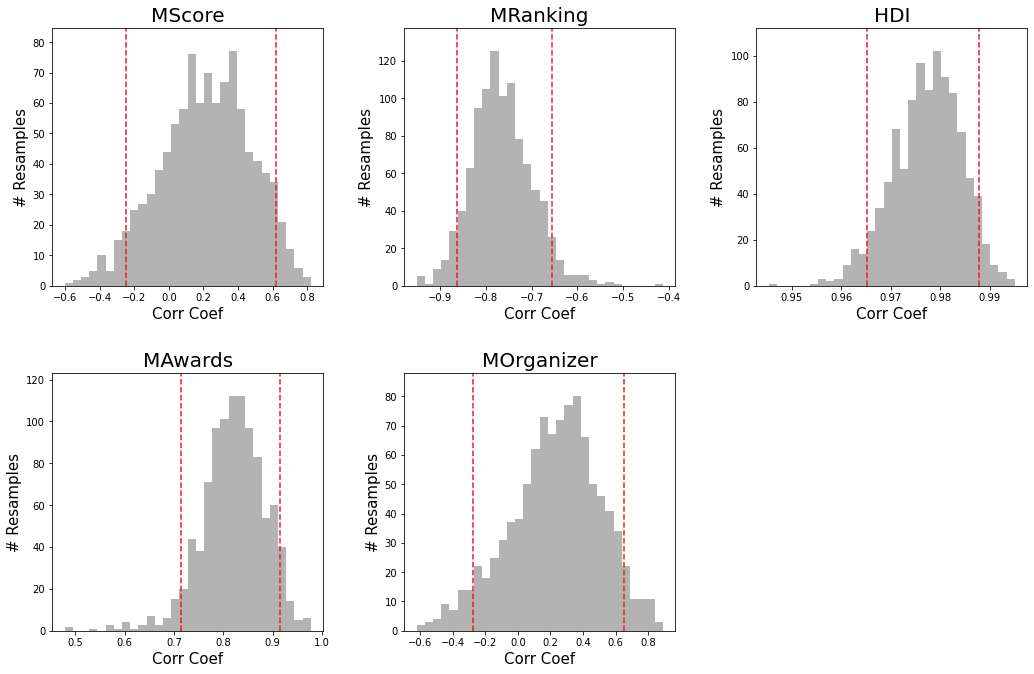

In [7]:
### Plot bootsrap distributions of correlation coefficients

# Features to use in analysis
features = ['MScore','MAwards','MRanking','MOrganizer','HDI']

# Degree of confindence
CI = 0.1 

#Define Fig
fig,axs = plt.subplots(2, 3, figsize=(15,10))

#Start subplot indices
rx = 0
cx = 0

# Plot sampling distributions histograms and CI intervals
for f in range(len(features)):
    ccs = boot_corrs(seasons_df,features[f], 'Players',1000) # Function that calculates resampling corr coefs
    l_prctile = np.percentile(ccs,CI*100/2)
    u_prctile = np.percentile(ccs,100 - (CI*100/2))
    
    counts,_,_ = axs[rx,cx].hist(ccs,30,color = '#B3B3B3')
    axs[rx,cx].plot([l_prctile, l_prctile],[0, max(counts)+max(counts)*0.1],color = '#E52123',linestyle = '--')
    axs[rx,cx].plot([u_prctile, u_prctile],[0, max(counts)+max(counts)*0.1],color = '#E52123',linestyle = '--')
    axs[rx,cx].set_title(features[f],fontsize = t_font)
    axs[rx,cx].set_xlabel('Corr Coef',fontsize = l_font)
    axs[rx,cx].set_ylabel('# Resamples',fontsize = l_font)
    axs[rx,cx].set_ylim(0, max(counts)+max(counts)*0.1)
  
    # change subplot indices
    if f%2 == 0:
        rx = 1
    else:
        rx = 0
        cx = cx + 1

#Delete empty axes
axs[1,2].axis("off")

fig.tight_layout(pad=3.0)
plt.show()
    



**Fig4.** Histograms of the correlation coefficients, between explanatory features and target variable, obtained in 1000 samples with replacement. In red the lower and upper limits for the confidence interval containing 90% of the distribution variables.   

----------

Per the Central Limit Theorem, a large number of random independent samples will always tend to approximate a normal distribution, even when the distribution of the original population is not normal. In such scenario the expected value for the coefficient of correlation between the features and the target variable is the mean of the distribution, the center of the confidence interval. 

The distributions I obtained are slightly skewed, preventing us to make such affirmation in a completely clear way. Still they allow us to see that HDI, MAwards and MRanking have strong and clear associations with the target variable: positive for the first two, negative for the second. Such is not the case for MScore and MOrganizer, where the value 0 is contained by the confidence interval.  

HDI, MAwards and MRanking are thus good candidates to the variables that most help to explain the evolution of the number of registered players across seasons. As previously discussed, only the last two are directly related to visibility and our question.   

# Effect of the explanatory features in predicting the evolution of registered players


The above correlations show the strength and signal of the association between the explanatory features and the target variable. As it is possible to see in the correlations matrix some explanatory variables are also very correlated among themselves. It is possible that the correlation of one feature with the target variable is achieved trough its correlation with another feature. For instance the FIFA Ranking of a national team is naturally linked to its results, results are also linked to the probability of obtaining awards, but what feature will have a bigger impact on the evolution of the number of players?   


One way of addressing such a scenario is to use a model to try to predict the target variable and regularization to allow the model to perform feature selection. I'll use regularized linear regression and a cross validation procedure to select the type (ratio between ridge and lasso) and strength of the regularization. The regularization will shrink towards 0 the coefficients of the features that per se are less useful to minimize the error between predictions and data.


## Model Performance


Before we can look at the features that are most useful to predict the target variable we need to make sure that the former actually contain information about the later, that our model has good performance when tested in data in which it was not trained. For such I'm going to use a nested cross validation procedure in which k outer folds are used to access the performance of the model and k inner folds are used, in each fit of the outer loop, to calculate the best hyper-parameters. 

The process was repeated 50 times and the results can be seen in **Fig5** bellow. 

In [8]:
### Separate train and test sest to fit LR models

# With IDH
X_0, y_0 = seasons_df.drop(['Players'], axis=1), seasons_df[['Players']]

#Wihout IDH 
X_1, y_1 = seasons_df.drop(['Players','HDI'], axis=1), seasons_df[['Players']]


In [9]:
### Estimate Performance with and without IDH using nested cross validation 

# Number of trials over wich to calculate performance
NUM_TRIALS = 50


# Arrays to store scores
nested_scores_0 = np.zeros((NUM_TRIALS,4)) # With IDH variable
nested_scores_1 = np.zeros((NUM_TRIALS,4)) # Without IDH variable

#Define scalers 
scaler_0 = MinMaxScaler() # Scales input variables between 0 and 1
scaler_1 = MinMaxScaler()

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i) # Define inner folds
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i) # Define outer folds


    # Nested CV with parameter optimization
    
    # With IDH variable
    clf_0 = ElasticNetCV(cv = inner_cv, l1_ratio = [.1, .5, .7, .9, .95, .99, 1],random_state = i)
    pipeline_0 = Pipeline([('sc', scaler_0), ('estimator', clf_0)])
    
    nested_score_0 = cross_val_score(pipeline_0, X=X_0, y=y_0.values.ravel(), cv=outer_cv)
    nested_scores_0[i,:] = nested_score_0
    
    
    # Without IDH variable
    clf_1 = ElasticNetCV(cv = inner_cv, l1_ratio = [.1, .5, .7, .9, .95, .99, 1],random_state = i)
    pipeline_1 = Pipeline([('sc', scaler_1), ('estimator', clf_1)])
    
    nested_score_1 = cross_val_score(pipeline_1, X=X_1, y=y_1.values.ravel(), cv=outer_cv)
    nested_scores_1[i,:] = nested_score_1
    

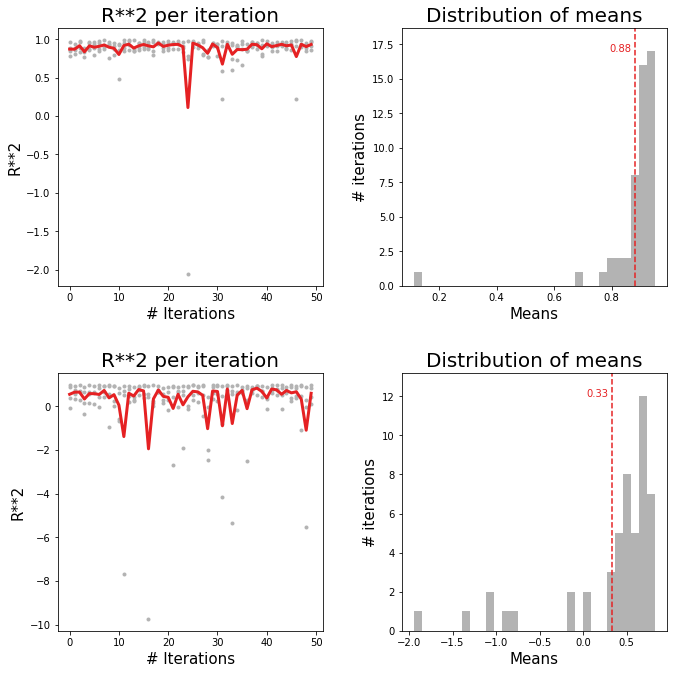

In [10]:
### Plot models performance

# With IDH
mean_its_0 = nested_scores_0.mean(axis=1)
mean_means_0 = mean_its_0.mean()

# Without IDH
nested_scores_1[nested_scores_1 < -10] = 0 # Eliminate 1 value with extreme R2 of -37
mean_its_1 = nested_scores_1.mean(axis=1)
mean_means_1 = mean_its_1.mean()


#Define Fig
fig,axs = plt.subplots(2, 2, figsize=(10,10)) # De

#Font Sizes
l_font = 15
t_font = 20
txt_font = 12


# Plot nested CV performances with IDH

axs[0,0].plot(nested_scores_0,'.',color='#B3B3B3',linewidth = 3)
axs[0,0].plot(mean_its_0,color='#E52123',linewidth = 3)
axs[0,0].set_xlabel('# Iterations',fontsize = l_font)
axs[0,0].set_ylabel('R**2',fontsize = l_font)
axs[0,0].set_title('R**2 per iteration',fontsize = t_font)

# Plot histogram of mean performances with IDH

counts,_,_ = axs[0,1].hist(mean_its_0,30,color='#B3B3B3')
axs[0,1].plot([mean_means_0, mean_means_0],
                [0, max(counts)+max(counts)*0.1],
                color = '#E52123',
                linestyle = '--')
axs[0,1].text(mean_means_0-0.09,max(counts),str(round(mean_means_0,2)),color = '#E52123')
axs[0,1].set_xlabel('Means',fontsize = l_font)
axs[0,1].set_ylabel('# iterations',fontsize = l_font)
axs[0,1].set_title('Distribution of means',fontsize = t_font)
axs[0,1].set_ylim(0, max(counts)+max(counts)*0.1)



# Plot nested CV performances  IDH

axs[1,0].plot(nested_scores_1,'.',color='#B3B3B3',linewidth = 3)
axs[1,0].plot(mean_its_1,color='#E52123',linewidth = 3)
axs[1,0].set_xlabel('# Iterations',fontsize = l_font)
axs[1,0].set_ylabel('R**2',fontsize = l_font)
axs[1,0].set_title('R**2 per iteration',fontsize = t_font)

# Plot histogram of mean performances without IDH

counts,_,_ = axs[1,1].hist(mean_its_1,30,color='#B3B3B3')
axs[1,1].plot([mean_means_1, mean_means_1],
                [0, max(counts)+max(counts)*0.1],
                color = '#E52123',
                linestyle = '--')
axs[1,1].text(mean_means_1-0.3,max(counts),str(round(mean_means_1,2)),color = '#E52123')
axs[1,1].set_xlabel('Means',fontsize = l_font)
axs[1,1].set_ylabel('# iterations',fontsize = l_font)
axs[1,1].set_title('Distribution of means',fontsize = t_font)
axs[1,1].set_ylim(0, max(counts)+max(counts)*0.1)


fig.tight_layout(pad=3.0)
plt.show()
    

**Fig5.** Top: results including HDI feature. Bottom: results without HDI feature. Left: R2 in each of the 4 test outer folds for the 50 repetitions - gray dots; Mean R2 in each trial - red line. Right: histogram of the mean R2 per trial; Dashed vertical line marks the mean. 

----------

An R2 (R squared) of 1 means that the features in our model totally explain the variance in the target variable, and an R2 of 0 means that the variables don't add more information than using as prediction the mean of the target variable. A negative R2 implies that the model with the explanatory variables did worst than just using the mean, which can happen when testing the model in held out data, particularly in small data sets.  


Above we can see that the explanatory features have information that can be used to predict the evolution of the number of registered players per season. In the vast majority of the train - test partitions of the cross validation process the R2 was higher than 0.

The instances of the model that include the HDI feature (top plots in **Fig5**) perform quite well: mean R2 per trial of 0.88 and more than 98% of the tests in all trials (gray dots in the above plots) with an R2 above 0.5. 

In the instances where HDI was not included, because it's not directly related with our question, the performances were worst but still positive: mean R2 per trial of 0.33 and about 65% of the tests in all trials with an R2 above 0.5.  


## Feature importance

Now that I trust that I can predict the target variable using the explanatory features I can look at their coefficients to understand which ones are the most important. To determine those I'll fit a model to the entire data set using cross validation to determine the regularization type (ratio between ridge and lasso) and strength. 

I'll fit one model with the feature HDI and one without. 

In [11]:
### Get the coefficents for the model with and without IDH


# With IDH
scaler_0 = MinMaxScaler()
clf_0 = ElasticNetCV(cv = inner_cv, l1_ratio = [.1, .5, .7, .9, .95, .99, 1],random_state = 1)
pipeline_0 = Pipeline([('sc', scaler_0), ('estimator', clf_0)])
pipeline_0.fit(X_0,y_0)


# Without IDH
scaler_1 = MinMaxScaler()
clf_1 = ElasticNetCV(cv = inner_cv, l1_ratio = [.1, .5, .7, .9, .95, .99, 1],random_state = 1)
pipeline_1 = Pipeline([('sc', scaler_1), ('estimator', clf_1)])
pipeline_1.fit(X_1,y_1)

#Print prediction scores
print(pipeline_0.score(X_0,y_0))
print(pipeline_1.score(X_1,y_1))

0.9790615586998894
0.8102974909333772


### Coefficients including HDI

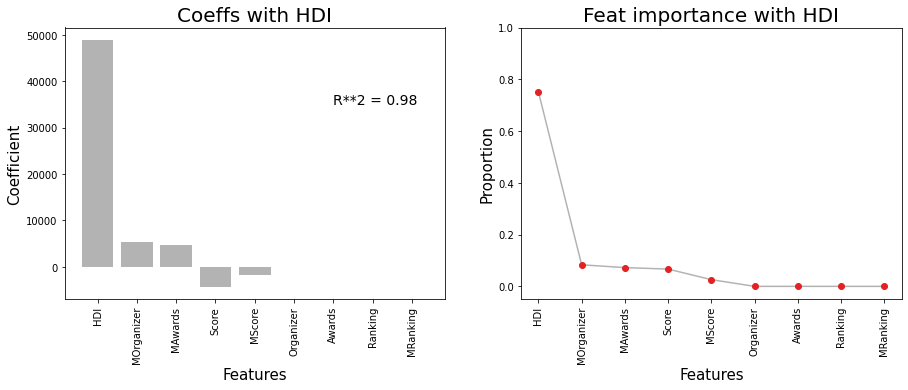

In [12]:
### Plot coefficients with IDH


#Get variables to plot
perf_0 = pipeline_0.score(X_0,y_0) # Performance
coef_vals_0 = pipeline_0[1].coef_ # Coefs
sorting_order_0 = np.argsort(np.abs(coef_vals_0)*-1)
sort_coefs_0 = coef_vals_0[sorting_order_0] # Sorted Coefs

coef_names_0 = pipeline_0[0].feature_names_in_ # Features names
sorted_names_0 = coef_names_0[sorting_order_0] # Sorted feature names



#Define Fig
fig,axs = plt.subplots(1, 2, figsize=(15,5)) 

#Font Sizes
l_font = 15
t_font = 20
txt_font = 12


# Plot sorted coefs
axs[0].bar(sorted_names_0,sort_coefs_0,color='#B3B3B3')
axs[0].text(sorted_names_0[6],35000,'R**2 = ' + str(round(perf_0,2)),fontsize = 14)
axs[0].set_xlabel('Features',fontsize = l_font)
axs[0].set_ylabel('Coefficient',fontsize = l_font)
axs[0].set_title('Coeffs with HDI',fontsize = t_font)
axs[0].set_xticklabels(sorted_names_0, rotation=90)



# Plot relative importance of coefs
axs[1].plot(sorted_names_0,np.abs(sort_coefs_0)/np.abs(sort_coefs_0).sum(),
            color='#B3B3B3',
            marker = 'o',
            mfc = '#E52123',
            mec = '#E52123')
axs[1].set_xlabel('Features',fontsize = l_font)
axs[1].set_ylabel('Proportion',fontsize = l_font)
axs[1].set_title('Feat importance with HDI',fontsize = t_font)
axs[1].set_xticklabels(sorted_names_0, rotation=90)
axs[1].set_ylim(-0.05,1)


plt.show()



**Fig6.** Results including HDI feature. Left: Coefficients determined by the model for each feature ordered by descending order of absolute value. Right: Relative importance of each feature in the final prediction.

----------

The model including the HDI feature explains 98% of the variance in the target variable, with HDI completely dominating the explanatory ability of the model, accounting for 75% of it.    

Our question pertains how visibility related variables influence the evolution of registered players and HDI is not one of those. Let's look at the model where the HDI variable was not included. 

### Coefficients without HDI 


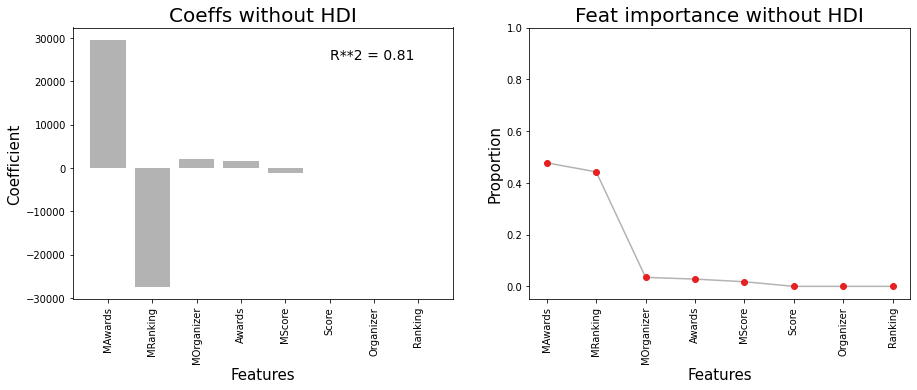

In [13]:
### Plot coefficients without IDH

#Get variables to plot
perf_1 = pipeline_1.score(X_1,y_1) # Performance
coef_vals_1 = pipeline_1[1].coef_ # Coefs
sorting_order_1 = np.argsort(np.abs(coef_vals_1)*-1)
sort_coefs_1 = coef_vals_1[sorting_order_1] # Sorted Coefs

coef_names_1 = pipeline_1[0].feature_names_in_ # Features names
sorted_names_1 = coef_names_1[sorting_order_1] # Sorted feature names


#Define Fig
fig,axs = plt.subplots(1, 2, figsize=(15,5)) # De


#Font Sizes
l_font = 15
t_font = 20
txt_font = 12


# Plot sorted coefs
axs[0].bar(sorted_names_1,sort_coefs_1,color='#B3B3B3')
axs[0].text(sorted_names_1[5],25000,'R**2 = ' + str(round(perf_1,2)),fontsize = 14)
axs[0].set_xlabel('Features',fontsize = l_font)
axs[0].set_ylabel('Coefficient',fontsize = l_font)
axs[0].set_title('Coeffs without HDI',fontsize = t_font)
axs[0].set_xticklabels(sorted_names_1, rotation=90)


# Plot relative importance of coefs
axs[1].plot(sorted_names_1,np.abs(sort_coefs_1)/np.abs(sort_coefs_1).sum(),
            color='#B3B3B3',
            marker = 'o',
            mfc = '#E52123',
            mec = '#E52123')
axs[1].set_xlabel('Features',fontsize = l_font)
axs[1].set_ylabel('Proportion',fontsize = l_font)
axs[1].set_title('Feat importance without HDI',fontsize = t_font)
axs[1].set_xticklabels(sorted_names_1, rotation=90)
axs[1].set_ylim(-0.05,1)


plt.show()


**Fig7.** Results without HDI feature. Left: Coefficients determined by the model for each feature ordered by descending order of absolute value. Right: Relative importance of each feature in the final prediction.

----------

The model without the HDI feature explains 88% of the variance in the target variable, the number of registered players per season. 

The most important features for the model's predictive power are MAwards (coef = 29561), and MRanking (coef = - 27416). These features contribution to the model are almost equal tough of different sign, as it was already clear from their correlations with the target variable and which makes sense given their meanings. 

There are other variables with coefficients different than 0, namely MOrganizer, Awards and MScore, but these only account for 3.4, 2.8 and 1.8% of the model's predictive power, respectively, a total of aprox 8%.  


# Final considerations

The original question motivating this small investigation was: what is the influence, in the number of registered football players per season, in Portugal, of different variables associated with the sport's overall visibility.   

After the above analysis the answer I can directly give to the question is that the visibility related features that better explain the evolution of the number of registered players per season are MRanking and MAwards, the two resulting of the transformation of the original variables Ranking and Awards. Together MRanking and MAwards account for more than 90% of the variance in the target variable that the model manages to explain, which agrees with the results previously obtained in the correlations analysis.  

The notion and quantification of the more or most important variable(s) are complex concepts. The analysis here conducted only shows that, given this particular set of data, the linear combination of features chosen by the model is the one that best minimizes the error to the target variable. Things can dramatically change with the introduction of new variables, as it is possible to see in the model in which the variable HDI was included. So the relative importance of a feature can very much change depending on the other features present on the model. We just have to look at the difference in importance of the variable MRanking in the models with and without HDI for an example. An analysis based in such a small data set is particularly sensitive to changes in the features and observations. 

Given that the question was about the visibility of the sport I think it would have been interesting to also use features directly related to it: publicity investment and campaigns, presence on the media (traditional and social), etc. After all these are the intermediaries between the performance of the national team and its visibility.  

The transformations performed on the original features were based in simple non-tested heuristics. With more time
deeper and more informed decisions could have been made. One could have conducted a grid search to look for the ideal temporal shift between features and target variable and window for the rolling means. More than simple tricks to improve the performance of the model these parameters might inform us of important ways the explanatory features relate to the target variable. 